<a href="https://colab.research.google.com/github/olexandr7/erm_workshop/blob/main/ERM_workshop_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Workshop 1** is focused on trying out textual manipulation

Let's now pick a museum collection from MuIS and try several operations:
* loading all items from collection
* making a word cloud out of item titles
* making a word cloud for a specific item - shaped like an item
* exporting collection to Excel

**Block 1**: installing relevant libraries for textual manipulation

In [1]:
#RDF scripts taken from rdflib tutorial:
#https://rdflib.readthedocs.io/en/stable/gettingstarted.html#a-more-extensive-example
#-------------------------------
#RDF manipulations
%pip install rdflib
#-------------------------------
#plotting
import matplotlib.pyplot as plt
#manipulations with dataframes
import pandas as pd
#URL requests loading
import urllib.request
#multidimensional arrays
import numpy as np
#image manipulation
import cv2
#---------------------------
#workaround to show opencv images in Colab
from google.colab.patches import cv2_imshow
#RDF manipulations - Graphics
from rdflib import Graph
#visualizing word cloud
from wordcloud import WordCloud
#downloading files from Colab
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.6 MB/s eta 0:00:00


**Block 2**: Displaying details of MuIS item in RDF
<br>  <font color='orange'>CHANGE:</font> Try changing URL to any other item from MUiS - there's a *püsiviide/permalink* for each item in UI
https://www.muis.ee/museaalview/1887998 -> https://opendata.muis.ee/object/1887998

In [2]:
# Create a Graph
g = Graph()
#this item could be viewed from MuIS UI via: https://www.muis.ee/museaalview/1887998
# Parse in an RDF file hosted on the Internet
g.parse("https://opendata.muis.ee/object/1887998")         #<---  URL could be changed to any item from MuIS
#displaying RDF contents - details about specific item
for s, p, o in g:
    print(s, p, o)
#Print out the entire Graph in the RDF Turtle format (added as just another example)
#print(g.serialize(format='turtle'))

Nbd0f1786efe7454395c3ceb1177235e2 http://www.cidoc-crm.org/cidoc-crm/P2_has_type http://opendata.muis.ee/thesaurus/49/2505
N8b509cf378a2478eb99b6542aff74456 http://www.w3.org/2002/07/owl#versionInfo version 1.0
N33c453de2f3648e5908db73034bcfec3 http://www.cidoc-crm.org/cidoc-crm/P2_has_type http://opendata.muis.ee/thesaurus/86/5251
N38a8eb8d3e8543b095551bb01fc8d899 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.cidoc-crm.org/cidoc-crm/E57_Material
http://opendata.muis.ee/object/1887998 http://opendata.muis.ee/rdf-schema/muis.rdfs#ks 1
http://opendata.muis.ee/object/1887998 http://opendata.muis.ee/rdf-schema/muis.rdfs#acr TLM
http://opendata.muis.ee/object/1887998 http://opendata.muis.ee/rdf-schema/muis.rdfs#kt H
Nbd0f1786efe7454395c3ceb1177235e2 http://www.cidoc-crm.org/cidoc-crm/P91_has_unit http://opendata.muis.ee/thesaurus/200/2571
http://opendata.muis.ee/object/1887998 http://www.w3.org/2000/01/rdf-schema#label Meeste kampsun / Jakk
N1a740643ad8c48ee8ac0f50466984329 htt

👕👕👕👕👕👕👕👕👕👕👕👕👕👕👕👕👕
<br>
**Dataset**: textile collection (Muuseumikogu: tekstiil) from Tallinna Linnamuuseum
<br>
http://www.muis.ee/rdf/collection/837
(change to bricks collection)
(why bricks - bricks load quicker)
(some examples here - where to get collection URL from exactly for people to test out later / in MuIS)


(seems like we also need to have limit on items of collection - so that we could load only like 50 first items)
(we could also try to have some other subsets, perhaps also on age/period of items)
(so yeah, let's have couple of filters on which items are loaded) - first 50 and also some historical periods

<br>
👕👕👕👕👕👕👕👕👕👕👕👕👕👕👕👕👕

---

**Block 3**: Loading all items from textile collection into a list
<br>  <font color='orange'>CHANGE:</font> Try changing URL to a different MuIS collection
(also show people how to change filters / add modifiers)
(let's also have filters in here)

In [3]:
g = Graph()
collectionitemslist = []

# Parse in an RDF file
g.parse("http://www.muis.ee/rdf/collection/837")    #<---CHANGE: could be changed to any collection from MuIS

#Textile collection - UI:
#https://www.muis.ee/museaalview:cataloguemuuseumkogu/93619-837?t:ac=1887998
#--------------------------------------------------------
#http://www.muis.ee/rdf/collection/837 #Textile collection
#http://www.muis.ee/rdf/collection/849 #Brick collection

#loop through triples
for s, p, o in g:
    if "P46_is_composed_of" in p: collectionitemslist.append(o)

#counting items within the list
count = 0
for items in collectionitemslist:
        count = count + 1
print("Total count of items in collection:", count)

Total count of items in collection: 4076


**Block 4**: Loading details for each of items into a dataframe
<br>
At the moment we're specifically interested in 2 fields:
*  item's URL
*  item's title

Since the collection could be quite extensive, we're going to load only 20 first items

<font color='orange'>CHANGE: </font> Try changing the column titles within datframe

In [4]:
#Generating dataset for wordcloud

#filtering out values from valid URLs, adding them into two lists
collectionitemslist_url = []
collectionitemslist_title = []

iter = 0

for i in collectionitemslist:
    g = Graph()
    try:
      g.parse(i)
      for s, p, o in g:
            if "http://opendata.muis.ee/object/" in s and "www.w3.org/2000/01/rdf-schema#label" in p:  print(iter, ':', o),  collectionitemslist_url.append(i), collectionitemslist_title.append(o)
      iter += 1
      if iter == 50:           #<---CHANGE: number of items to load could be adjusted
        break
    except Exception:
        pass
#making dataframe out of 2 lists
df = pd.DataFrame(list(zip(collectionitemslist_url, collectionitemslist_title)))
df = df.rename(columns={0: 'URL', 1: 'Title'})

#displaying dataframe
df

0 : Linik
1 : Naiste sõrmkinnas
2 : Vimpel komplektist "Eestimaa isandad läbi aegade"
3 : Aluskuub / Naiste aluskleit
4 : Linik tualettlaua komplektist
5 : Vimpel "Olümpiatule teatejooks"
6 : Kummutilina
7 : Kleidikaunistus helmestest
8 : Tekilina
9 : Naiste labakindad
10 : Poeglapse ristimiskleit
11 : Dekoratiivkanga näidis
12 : Beebiteki lina
13 : Sukad
14 : Naiste pluus
15 : Kleidikaeluse kaunistus
16 : Paelaga tutt, Mustpeade Vennaskond
17 : Juuksenõelapitsi proovid, pesukaunistus
18 : T-särk "Mina olen eurooplane"
19 : Lipp ja lipuvarras. Tallinna linn
20 : Sukad
21 : Naiste sõrmkindad
22 : Vimpel  "ENSV Üldlaulupidu 1869-1969"
23 : Lõkme. Eestimaa kubermangu ametnik kolleegiumiassessori astmes
24 : Öösärk. "Marat"
25 : Aknakardinad
26 : Vaheriie / Riidenäidis
27 : Naiste sõrmkinnas
28 : Naiste sukapüksid. "Punane Koit"
29 : Juuksepaelad
30 : Poeglapse ristimistanu
31 : Naiste särk
32 : Salvrätik
33 : Vimpel "Oт cпартакoвцев Латвии конькoбежцaм Эстонии." 
34 : Meeste päevasärk. Sõ

,URL,Title
0,http://opendata.muis.ee/object/1201350,Linik
1,http://opendata.muis.ee/object/4333552,Naiste sõrmkinnas
2,http://opendata.muis.ee/object/1912934,"Vimpel komplektist ""Eestimaa isandad läbi aegade"""
3,http://opendata.muis.ee/object/1873661,Aluskuub / Naiste aluskleit
4,http://opendata.muis.ee/object/1926291,Linik tualettlaua komplektist
5,http://opendata.muis.ee/object/1859600,"Vimpel ""Olümpiatule teatejooks"""
6,http://opendata.muis.ee/object/1875751,Kummutilina
7,http://opendata.muis.ee/object/1879847,Kleidikaunistus helmestest
8,http://opendata.muis.ee/object/1202446,Tekilina
9,http://opendata.muis.ee/object/1899824,Naiste labakindad


No charts were generated by quickchart


🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖
<br>
Let's try using Colab functionality (auto-suggestions or built-in AI) and *generate frequency chart* automatically
<br>🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖🤖

**Block 4**: Making word cloud out of loaded collection data (item titles)
<br>  <font color='orange'>Action point: </font> Try changing how the word cloud is displayed (e.g. axis mode)
should find some way to modify the cloud visually

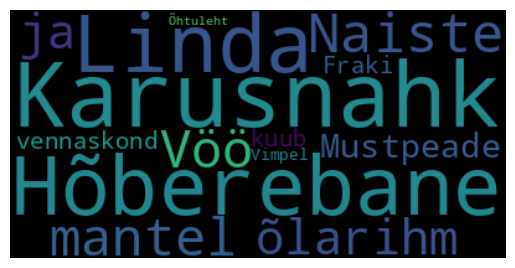

In [ ]:
#Creating wordcloud based on example from:
#https://github.com/amueller/word_cloud/blob/main/examples/simple.py

#additional filtering could be applied if needed --should remove
#df = df[df['Label'].str.contains("Kleit")]
#creating a single string with all values from title column
df_joined = ' '.join(df['Title'].to_list())

#creating wordcloud
wordcloud = WordCloud(max_font_size=80, background_color="black", contour_color='steelblue') #<---CHANGE: background color could be modified
#generating word cloud from data (single string with all values)
wordcloud.generate(df_joined)


plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#displaying word cloud
plt.show()

In [ ]:
**Block 5**: Making word cloud out of one item in the shape of the same item


<br>  <font color='orange'>CHANGE: </font> Try changing how the word cloud is displayed (e.g. axis mode)
should find some way to modify the cloud visually

In [ ]:
#loading data for specific item
g = Graph()
tinycollectionitemslist_url = []
tinycollectionitemslist_label = []

#parsing sled blanket: https://www.muis.ee/museaalview/1537361
g.parse("https://opendata.muis.ee/object/1537361")
for s, p, o in g:
  if "http://opendata.muis.ee/object/" not in s and "rdf-schema#label" in p and "tervik" not in o:  tinycollectionitemslist_url.append(i), tinycollectionitemslist_label.append(o)

#making dataframe out of 2 lists
df_tiny = pd.DataFrame(list(zip(tinycollectionitemslist_url, tinycollectionitemslist_label)))
df_tiny = df_tiny.rename(columns={0: 'URL',1: 'Label'})
#creating a single string with all values from label  column
df_joined_tiny = ' '.join(df_tiny['Label'].to_list())
df_joined_tiny

'Tikitud saanitekk, hallist kodukootud villasest riidest. Vaiba ühte äärde tikitud villaste lõngadega mitmevärviline tikand, mis koosneb punakais toonides õitest ja ruudukestest kollakais-rohekais toonides lehtedest ja joontest. Servad masinpalistusega.'

**Block 6**: Manupulating masking image


<br>  <font color='orange'>CHANGE: </font> Try changing how the word cloud is displayed (e.g. axis mode)
should find some way to modify the cloud visually

In [ ]:
#https://www.muis.ee/museaalview/402105

# read the mask image
url = "https://www.muis.ee/digitaalhoidla/api/meedia/pisipilt?id=650d7c6d-a6e5-47c6-8c8a-3531bdd5f54c"  #<---  URL could be changed to any image from MuIS
url_response = urllib.request.urlopen(url)
mask_image = cv2.imdecode(np.array(bytearray(url_response.read()), dtype=np.uint8), -1)

#converting image to greyscale
mask_image_grey = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)


#adaptive thresholding
mask_image_grey = cv2.medianBlur(mask_image_grey,5)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(mask_image_grey,(5,5),0)
ret3,mask_image_binarized = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2_imshow(mask_image_binarized)

**Block 7**: Manupulating masking image


<br>  <font color='orange'>CHANGE: </font> Try changing how the word cloud is displayed (e.g. axis mode)
should find some way to modify the cloud visually

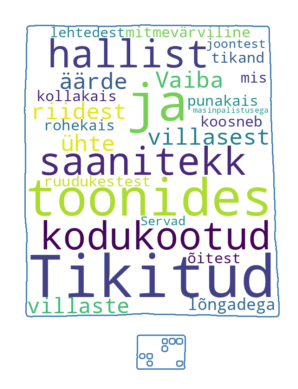

In [ ]:
#example taken from:
#https://github.com/amueller/word_cloud/blob/main/examples/masked.py
#https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

wc = WordCloud(background_color="white", max_words=1000, max_font_size=400, mask=mask_image_binarized,
              contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(df_joined_tiny)

# show
plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓
<br>Let's now look into exporting MuIS content into Excel file
<BR>
📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓

**Block 5**: Loading item details into a dataframe - choosing column that we would like to see in output (excel) file
<br>  <font color='orange'>Action point: </font> Try changing how the word cloud is displayed (e.g. axis mode)

we should explain why those specific columns are exported
people could work on it later or something

In [ ]:
#filtering out values from valid URLs, adding them into multiple lists
collectionitemslist_url = []
collectionitemslist_title = []
collectionitemslist_label = []
collectionitemslist_availabiletime = []
collectionitemslist_identifier = []
collectionitemslist_publisher = []
collectionitemslist_collection = []
it = 0

for i in collectionitemslist:
    g = Graph()
    try:
        it += 1
        g.parse(i)
        for s, p, o in g:
            if "http://opendata.muis.ee/object/" in s and "www.w3.org/2000/01/rdf-schema#label" in p:  print(it), collectionitemslist_url.append(i), collectionitemslist_title.append(o)
            if "purl.org/dc/terms/available" in p:  print(it), collectionitemslist_url.append(i), collectionitemslist_availabiletime.append(o)
            if "purl.org/dc/terms/identifier" in p:  print(it), collectionitemslist_url.append(i), collectionitemslist_identifier.append(o)
            if "purl.org/dc/elements/1.1/publisher" in p:  print(it), collectionitemslist_url.append(i), collectionitemslist_publisher.append(o)
            if "http://opendata.muis.ee/object/" in s and "cidoc-crm/P46i_forms_part_of" in p and "/collection/" in o:  print(it), collectionitemslist_url.append(i), collectionitemslist_collection.append(o)
            if "http://opendata.muis.ee/object/" not in s and "rdf-schema#label" in p and "tervik" not in o:  print(it), collectionitemslist_url.append(i), collectionitemslist_label.append(o)
    except:
        pass

#making dataframe out of lists
df = pd.DataFrame(list(zip(collectionitemslist_url, collectionitemslist_title, collectionitemslist_label,
                           collectionitemslist_availabiletime, collectionitemslist_identifier, collectionitemslist_publisher, collectionitemslist_collection)))
df = df.rename(columns={0: 'URL',1: 'Title', 2: 'Label', 3: 'Made available', 4: 'Identifier', 5: 'Publisher', 6: 'Collection'})
#df = df[df['Label'].str.contains("tervik") == False]  #filtering out values with "tervik"

In [ ]:
df

**Block 6**: Exporting dataframe to excel file
<br>  <font color='orange'>Action point: </font> Try changing the excel file name

disppointing factopr of excel is lack of columns - we could have more
would be good to have some more columns in excel


how do we know if this things is a success
research questions:
community needs
support museums for co-creation

In [ ]:
#file export out
df.to_excel("labels.xlsx")          #<--- file name could be changed
#downloading file from browser
files.download('labels.xlsx')       #<--- file name could be changed